# 03 Jet tagging

Goal of this notebook:

 - Use the `Weaver` framework to train a neural network to discriminate top jets versus QCD jets.

This notebook is a simplified version of the tutorial page: https://cms-ml.github.io/documentation/inference/particlenet.html#introduction-to-particlenet.
For advanced learners, please refer to the details in the webpage.

In [1]:
import os
# Determine the base directory and the remote git path
hostname = os.uname()[1]
if 'pku.edu.cn' in hostname: # on PKU cluster
    basedir = '/data/pubfs/pku_visitor/public_write/ML/top_tagging/'
    gitaddr = 'https://gitee.com/colizz/weaver-benchmark.git'
elif 'thu' in hostname: # on THU cluster
    basedir = '/data/pubfs/pku_visitor/public_write/ML/top_tagging/'
    gitaddr = 'https://gitee.com/colizz/weaver-benchmark.git'
elif hostname.startswith('lxslc'): # on IHEP lxslc
    basedir = '/scratchfs/cms/licq/cmschina/ML/top_tagging/'
    gitaddr = 'https://gitee.com/colizz/weaver-benchmark.git'
elif hostname.startswith('lxplus'): # on CERN lxplus
    basedir = '/eos/user/c/coli/public/weaver-benchmark/top_tagging/samples/'
    gitaddr = 'https://github.com/colizz/weaver-benchmark.git'
else:
    raise RuntimeError('Machine not supported')

In [2]:
# Clone the weaver repo here
![ -d weaver-benchmark ] || \
  (git clone --recursive $gitaddr; \
  ln -s ../top_tagging weaver-benchmark/weaver/top_tagging; \
  cd weaver-benchmark/weaver/; \
  mkdir output)

# Change the working directory
os.chdir('weaver-benchmark/weaver/')

Cloning into 'weaver-benchmark'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 71 (delta 21), reused 67 (delta 17), pack-reused 0
Unpacking objects: 100% (71/71), done.
Submodule 'weaver' (https://github.com/hqucms/weaver.git) registered for path 'weaver'
Cloning into 'weaver'...
remote: Enumerating objects: 420, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 420 (delta 116), reused 107 (delta 95), pack-reused 259
Receiving objects: 100% (420/420), 147.23 KiB | 0 bytes/s, done.
Resolving deltas: 100% (267/267), done.
Submodule path 'weaver': checked out 'f7d5b720261c57557204eb07bfe215ed43ddf743'


## Start training. 

We will run a shell command inside the notebook.

The training command follows the tutorial https://cms-ml.github.io/documentation/inference/particlenet.html#2-start-training. 

We use the MLP model (i.e. the feed-forward network) for this notebook.

In [3]:
## Training on CPUs, only for 3 epoches
PREFIX='mlp'
MODEL_CONFIG='mlp_pf.py'
DATA_CONFIG='pf_features.yaml'
!python -u train.py \
 --data-train {basedir}'/prep/top_train_*.root' \
 --data-val {basedir}'/prep/top_val_*.root' \
 --fetch-by-file --fetch-step 1 --num-workers 3 \
 --data-config top_tagging/data/$DATA_CONFIG \
 --network-config top_tagging/networks/{MODEL_CONFIG} \
 --model-prefix output/{PREFIX} \
 --gpus '' --batch-size 1024 --start-lr 5e-3 --num-epochs 3 --optimizer ranger \
 --log output/{PREFIX}.train.log \
 --tensorboard {PREFIX}

[2021-12-12 13:06:07,997] INFO: args:
 - ('regression_mode', False)
 - ('data_config', 'top_tagging/data/pf_features.yaml')
 - ('data_train', ['/eos/user/c/coli/public/weaver-benchmark/top_tagging/samples//prep/top_train_*.root'])
 - ('data_val', ['/eos/user/c/coli/public/weaver-benchmark/top_tagging/samples//prep/top_val_*.root'])
 - ('data_test', [])
 - ('data_fraction', 1)
 - ('file_fraction', 1)
 - ('fetch_by_files', True)
 - ('fetch_step', 1.0)
 - ('in_memory', False)
 - ('train_val_split', 0.8)
 - ('demo', False)
 - ('lr_finder', None)
 - ('tensorboard', 'mlp')
 - ('tensorboard_custom_fn', None)
 - ('network_config', 'top_tagging/networks/mlp_pf.py')
 - ('network_option', [])
 - ('model_prefix', 'output/mlp')
 - ('num_epochs', 3)
 - ('steps_per_epoch', None)
 - ('steps_per_epoch_val', None)
 - ('optimizer', 'ranger')
 - ('optimizer_option', [])
 - ('lr_scheduler', 'flat+decay')
 - ('load_epoch', None)
 - ('start_lr', 0.005)
 - ('batch_size', 1024)
 - ('use_amp', False)
 - ('gpus'

In [4]:
# When you see Epoch #2 has finished (you trained 3 epoches already), you can predict the score with last-epoch model
!python train.py --predict \
 --data-test {basedir}'/prep/top_test_*.root' \
 --num-workers 3 \
 --data-config top_tagging/data/{DATA_CONFIG} \
 --network-config top_tagging/networks/{MODEL_CONFIG} \
 --model-prefix output/{PREFIX}_epoch-2_state.pt \
 --gpus '' --batch-size 1024 \
 --predict-output output/{PREFIX}_predict.root

[2021-12-12 13:14:07,219] INFO: args:
 - ('regression_mode', False)
 - ('data_config', 'top_tagging/data/pf_features.yaml')
 - ('data_train', [])
 - ('data_val', [])
 - ('data_test', ['/eos/user/c/coli/public/weaver-benchmark/top_tagging/samples//prep/top_test_*.root'])
 - ('data_fraction', 1)
 - ('file_fraction', 1)
 - ('fetch_by_files', False)
 - ('fetch_step', 0.01)
 - ('in_memory', False)
 - ('train_val_split', 0.8)
 - ('demo', False)
 - ('lr_finder', None)
 - ('tensorboard', None)
 - ('tensorboard_custom_fn', None)
 - ('network_config', 'top_tagging/networks/mlp_pf.py')
 - ('network_option', [])
 - ('model_prefix', 'output/mlp_epoch-2_state.pt')
 - ('num_epochs', 20)
 - ('steps_per_epoch', None)
 - ('steps_per_epoch_val', None)
 - ('optimizer', 'ranger')
 - ('optimizer_option', [])
 - ('lr_scheduler', 'flat+decay')
 - ('load_epoch', None)
 - ('start_lr', 0.005)
 - ('batch_size', 1024)
 - ('use_amp', False)
 - ('gpus', '')
 - ('num_workers', 3)
 - ('predict', True)
 - ('predict_out

## Play with TensorBoard

Now you have finished the training and also validation step. You see an output ROOT file is written to output/mlp_predict.root.

You can play with the TensorBoard log written for each mini-batch of training and validation.

In [5]:
# Launch a tensorboard service in the background
import random
my_tb_port = random.choice(range(6000, 9999))
print(f'Will launch a TensorBoard service on *this machine* in the port {my_tb_port}\n')

import subprocess
p = subprocess.Popen(['tensorboard', '--logdir', 'runs', '--port', str(my_tb_port)])

# some instructions
import getpass, os
username = getpass.getuser()
hostname = os.uname()[1]
print(f'''Now you need to access to this specific port.
Establish a new SSH tunnel from your leptop by 
    ssh -L {my_tb_port}:localhost:{my_tb_port} -p <port> <user>@<host>

depending on how you connect to the current machine with "ssh -p <port> <user>@<host>"

note: if PKU cluster is not directly accessiable at the moment, try to route via the cmschina server using this long command (replace <user> with your PKU username)
    ssh -L {my_tb_port}:localhost:{my_tb_port} -p 9001 <user>@localhost -o ProxyCommand="ssh cmschina@81.70.42.130 nc %h %p"


then access the link from your own browser
    http://localhost:{my_tb_port}/''')

Will launch a TensorBoard service on *this machine* in the port 8846

Now you need to access to this specific port.
Establish a new SSH tunnel from your leptop by 
    ssh -L 8846:localhost:8846 -p <port> <user>@<host>

depending on how you connect to the current machine with "ssh -p <port> <user>@<host>"

note: if PKU cluster is not directly accessiable at the moment, try to route via the cmschina server using this long command (replace <user> with your PKU username)
    ssh -L 8846:localhost:8846 -p 9001 <user>@localhost -o ProxyCommand="ssh cmschina@81.70.42.130 nc %h %p"


then access the link from your own browser
    http://localhost:8846/


2021-12-12 13:27:25.444476: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-12 13:27:25.444565: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-12 13:27:39.486851: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-12 13:27:39.486940: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lxplus796.cern.ch): /proc/driver/nvidia/version does not exist
/afs/cern.ch/user/c/coli/work/ml/miniconda/envs/ml/lib/python3.9/site-packages/tensorboard_data_server/bin/server: /lib64/libc.so.6: version `GLIBC_2.18' not found (required by /afs/cern.ch/user/c/coli/work/ml/miniconda/envs/ml/lib/python3.9/

In [6]:
# if you want to terminate the TensorBoard service, uncommand and run the following line

# p.terminate()

2021-12-12 13:27:19.760439: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-12 13:27:19.760706: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Evaluate the result

In [7]:
import uproot
import awkward as ak
import numpy as np

# Use boost_histogram to make a histogram
import boost_histogram as bh

import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
# make ROOT-style plots using python package matplotlib
plt.style.use(hep.style.ROOT)

branches of the output ROOT file:  ['is_signal_new', 'score_is_signal_new', 'is_bkg', 'score_is_bkg', 'origIdx', 'idx', 'E_tot', 'PX_tot', 'PY_tot', 'PZ_tot', 'P_tot', 'Eta_tot', 'Phi_tot']


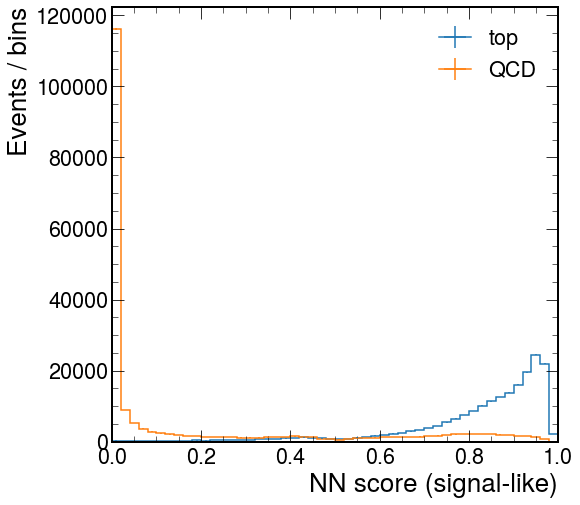

In [8]:
# Draw the predicted score distribution

df = uproot.lazy('output/mlp_predict.root')
print('branches of the output ROOT file: ', ak.fields(df))
y_pred_sig_score = df.score_is_signal_new

f, ax = plt.subplots(figsize=(8, 8))
for idx, lab in zip([df.is_signal_new == True, df.is_signal_new == False], ['top', 'QCD']):
    hist = bh.Histogram(bh.axis.Regular(50, 0., 1.), storage=bh.storage.Weight())
    hist.fill(y_pred_sig_score[idx])
    content, yerr = hist.view().value, np.sqrt(hist.view().variance)
    # plot the histogram
    hep.histplot(content, bins=hist.axes[0].edges, yerr=yerr, label=lab)
ax.set_xlabel('NN score (signal-like)', ha='right', x=1.0)
ax.set_ylabel('Events / bins', ha='right', y=1.0)
ax.set_xlim(0, 1)
ax.legend()

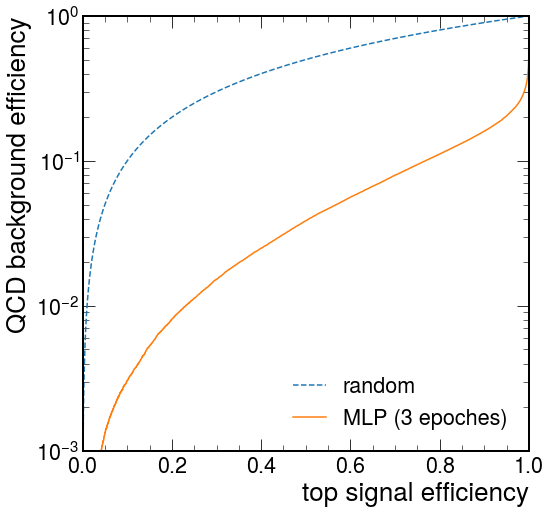

In [9]:
# Draw the ROC curve

import sklearn.metrics as m
fpr, tpr, _thres = m.roc_curve(df.is_signal_new, df.score_is_signal_new)

import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
# make ROOT-style plots using python package matplotlib
plt.style.use(hep.style.ROOT)

# Plot the ROC curve
f, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), '--', label='random')
ax.plot(tpr, fpr, label='MLP (3 epoches)')

ax.set_yscale('log'); ax.set_xlim(0, 1); ax.set_ylim(1e-3, 1)
ax.set_xlabel('top signal efficiency', ha='right', x=1.0); ax.set_ylabel(r'QCD background efficiency', ha='right', y=1.0)
ax.legend()